In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

img_height, img_width, channels = 256, 256, 3

#Look into stalling the program until the predictions are made

Num GPUs Available:  1


In [6]:
vit_classifier = tf.keras.models.load_model('./shell_script/vit_classifier')
vit_classifier.load_weights('./shell_script/model_weights.h5') 

In [5]:
# vit_classifier.load_weights('../Project/shell_script/model_weights.h5')

In [7]:
#image_path = './TEST.png'
image_path = './asl-alphabet/asl_alphabet_test/G/G1262.jpg'


img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  

predictions = vit_classifier.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
predicted_label = class_names[predicted_class]

confidence = np.max(tf.nn.softmax(predictions)) * 100

print(f"Predicted Sign: {predicted_label}")
print(f"Confidence: {confidence:.2f}%")

Predicted Sign: G
Confidence: 100.00%


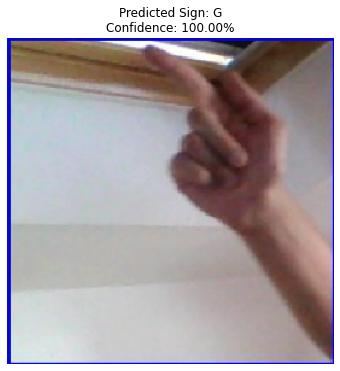

<Figure size 432x288 with 0 Axes>

In [8]:
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Sign: {predicted_label}\nConfidence: {confidence:.2f}%")
plt.show()
plt.clf()

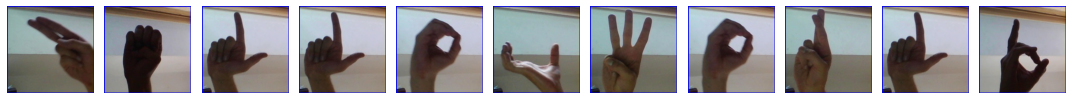

In [9]:
image_paths = [
    './asl-alphabet/asl_alphabet_train/H/H1.jpg',
    './asl-alphabet/asl_alphabet_train/E/E1.jpg',
    './asl-alphabet/asl_alphabet_train/L/L1.jpg',
    './asl-alphabet/asl_alphabet_train/L/L1.jpg',
    './asl-alphabet/asl_alphabet_train/O/O1.jpg',
    './asl-alphabet/asl_alphabet_train/space/space1.jpg',
    './asl-alphabet/asl_alphabet_train/W/W1.jpg',
    './asl-alphabet/asl_alphabet_train/O/O1.jpg',
    './asl-alphabet/asl_alphabet_train/R/R1.jpg',
    './asl-alphabet/asl_alphabet_train/L/L1.jpg',
    './asl-alphabet/asl_alphabet_train/D/D1.jpg'
]

plt.figure(figsize=(15, 3))
for idx, image_path in enumerate(image_paths):
    img = mpimg.imread(image_path)
    plt.subplot(1, len(image_paths), idx + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
def crop_frame(frame):
    h, w, _ = frame.shape
    crop_x = int(w * 0.1)
    crop_y = int(h * 0.1)
    
    cropped_frame = frame[crop_y:h-crop_y, crop_x:w-crop_x]
    
    return cropped_frame

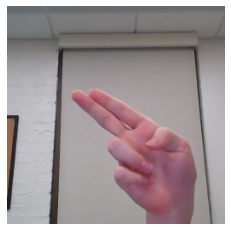

Predicted class: 1, Confidence: 99.99619722366333
Predicted sign: B


In [11]:
testFrame = './Frame1.png'
frame = cv2.imread(testFrame)

frame = crop_frame(frame)
frame = cv2.resize(frame, (img_width, img_height))

frame = frame.astype('float32') * (1.0 / 255.0)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
processed_frame = np.expand_dims(frame, axis=0)

plt.imshow(processed_frame[0])
plt.axis('off')
plt.show()

prediction = vit_classifier.predict(processed_frame)
predicted_class = np.argmax(prediction, axis=1)[0]
confidence = np.max(tf.nn.softmax(prediction)) * 100

print(f"Predicted class: {predicted_class}, Confidence: {confidence}")
print(f"Predicted sign: {class_names[predicted_class]}")

In [12]:
# Initialize variables
frame_count = 0
translation = []
classified_frames = {}
debounce = False
confidence_threshold = 80.0
tracked_signs = []

# Open video file
videoFile = './ASLvideo.mp4'
video = cv2.VideoCapture(videoFile)

# Validate video opening
if not video.isOpened():
    print("Error: Could not open video file.")
    exit()

# Calculate frame sampling
fps = int(video.get(cv2.CAP_PROP_FPS))
frame_interval = 5

# Video processing loop
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
    
    frame_count += 1
    
    # Process frames at specified interval
    if frame_count % frame_interval == 0:
        # Preprocess frame
        processed_frame = crop_frame(frame)
        processed_frame = cv2.resize(processed_frame, (img_width, img_height))
        processed_frame = processed_frame.astype('float32') * (1.0 / 255.0)
        processed_frame = np.expand_dims(processed_frame, axis=0)
        
        # Make prediction
        prediction = vit_classifier.predict(processed_frame)
        predicted_class = np.argmax(prediction, axis=1)[0]
        confidence = np.max(tf.nn.softmax(prediction)) * 100
        
        
        # Store frame classification details
        classified_frames[frame_count] = {
            "frame": frame.copy(),
            "confidence": confidence,
            "predicted_class": predicted_class,
            "prediction": prediction.tolist(),
        }
        
        # Translation logic with improved handling
        if confidence > confidence_threshold:
            current_sign = class_names[predicted_class]
            
            # Ignore certain classes
            if current_sign not in ["del", "nothing", "space"]:
                # Prevent repeated signs
                if not tracked_signs or tracked_signs[-1] != current_sign:
                    translation.append(current_sign)
                    tracked_signs.append(current_sign)
                    debounce = True
            
            # Space handling
            elif current_sign == "space":
                if translation and translation[-1] != " ":
                    translation.append(" ")
                    tracked_signs.append(" ")
                debounce = True
            
            # elif current_sign == "del" and translation:
            #     translation.pop()
            #     tracked_signs.pop() if tracked_signs else None
            #     debounce = True
        
        elif predicted_class == class_names.index("nothing"):
            debounce = False
            tracked_signs.clear()

# Clean up
video.release()

# Print final translation
print(''.join(translation))
print(f"Total frames processed: {frame_count}")
print(f"Total signs translated: {len(translation)}")

YYYYYY
Total frames processed: 1491
Total signs translated: 6


In [13]:
def display_and_get_prediction(frame_count, classified_frames):
    if frame_count in classified_frames:
        classified_frame = classified_frames[frame_count]
        frame = classified_frame["frame"]
        predicted_class = classified_frame["predicted_class"]
        confidence = classified_frame["confidence"]

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        plt.imshow(frame_rgb)
        plt.title(f'Predicted: {class_names[predicted_class]} with {round(confidence)}% confidence')
        plt.axis('off')
        plt.show()

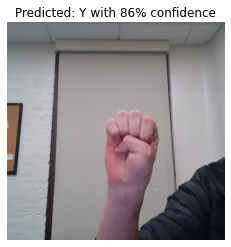

In [14]:
display_and_get_prediction(200, classified_frames)

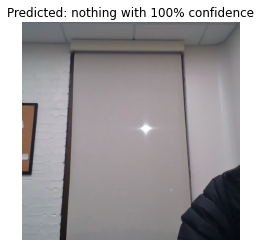

In [15]:
display_and_get_prediction(5, classified_frames)

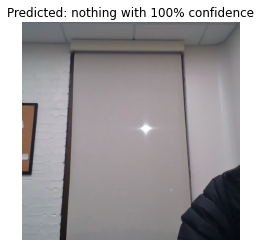

In [16]:
display_and_get_prediction(5, classified_frames)